In [8]:
# Dynamic
# %matplotlib notebook
# Standard
%matplotlib inline

from os.path import join, isdir, basename
from glob import iglob
import sys
import json
import pickle
import pandas
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import draw_learning_curve

# Allow to import the modules in the model folder
sys.path.append('../model/')

fig_width = 16 # full screen: 16 / half screen: 10
fig_height = 8

# path of the folder with the results
res_path = '../model/res/'

In [2]:
def aggregated_learning_curve(cluster_sim_path, param_filter=''):
    """
    - cluster_sim_path:  name of the folder with all the results
    -param_filter:  choose only the sub-folder in cluster_sim_path
        with the param_filter value in their name
    """
    
    path = cluster_sim_path

    run_paths = sorted([run_path for run_path in iglob(join(path, '*')) if isdir(run_path)])
    
    options_list = []
    seeds = set()
    sims = set()
    for path in run_paths:
        options = basename(path).split("+", 1)
        for i, option in enumerate(options):
            if i == 0:
                s = seeds
            else:
                if param_filter and param_filter not in option:
                    continue
                s = sims
            s.add(option)

    seeds = sorted(list(seeds))
    sims = natsorted(list(sims))
    
    print("number of seed:", len(seeds))
    print("number of simulation:", len(sims))
    
    # -- Define the number of abscisse value --
    sim_name = '+'.join([seeds[0], sims[0]])
    path = cluster_sim_path + sim_name
    with open(join(path, 'conf.json'), 'r') as f:
        run_param = json.load(f)
    nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

    # -- Initialization of the figure --
    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = fig.gca()
    for i in range(1, nb_steps, 2):
        ax.axvspan(i, i+1, facecolor='darkblue', alpha=0.1)
    ax.set_xticks(range(0, nb_steps, 20))
    ax.set_xticklabels(range(0, nb_steps//2, 10))
    ax.set_xlim(0, nb_steps)
    ax.set_xlabel('Day')
#     ax.set_yscale('log') # log scale on the ordinate (not sure if usefull)
    ax.set_ylabel('Error distance from tutor')
    ax.set_title('Learning curve')
    
    for sim in sims:
#         print("sim:", sim)
        mean_score = None

        # FIXME: the number of C color value is limited
        color='C{}'.format(sims.index(sim))
        
        for seed in seeds:
            sim_name = '+'.join([seed, sim])
            path = cluster_sim_path + sim_name

            with open(join(path, 'data.pkl'), 'rb') as f:
                songlog = pickle.load(f)
            root_data = [item[1] for item in songlog if item[0] == 'root']
            rd = pandas.DataFrame(root_data)
            score_array = np.array([list(a) for a in rd['scores']]).T

            # -- Plot all the learning curves --
            for scores in score_array:
                plt.plot(scores, color=color, alpha=0.1)

            # -- Plot the mean learning curve of one parameter set--
            if mean_score is None:
                mean_score = score_array
            else:
                mean_score = np.concatenate((mean_score, score_array), axis=0)
        mean_score = np.mean(mean_score, axis=0)
        final_score = round(mean_score[-1], 3)
        
        # hard fix specific case: shorten the name in the legend of the plot
        if "nlm_div_th_test" in sim:
            sim = sim.split("+")[2]
        
        plt.plot(mean_score, color=color,
                 label='{} ({})'.format(sim, final_score))


        ############
        # TODO: try to use seaborn and lineplot function
        ############

    #     print(mean_score.shape)
    #     print(len(np.arange(1, mean_score.shape[1] + 1)))
    #     sns.lineplot(x=np.arange(1, mean_score.shape[1] + 1),y=mean_score.T)
    plt.legend(fontsize="small")
    plt.show()

number of seed: 5
number of simulation: 3


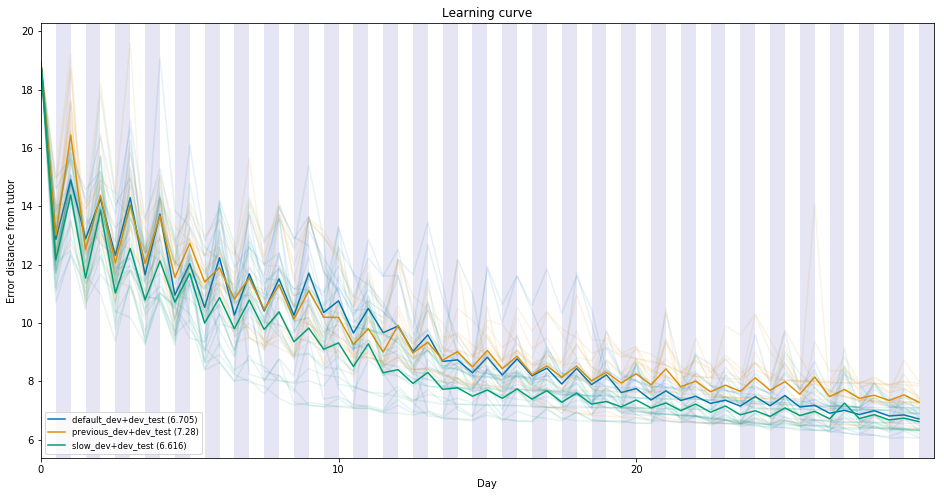

In [9]:
# -- Cluster simulations --
cluster_sim_path = res_path + 'dev_test_180717_115457/'

param_filter = ''

aggregated_learning_curve(cluster_sim_path, param_filter=param_filter)

number of seed: 5
number of simulation: 9


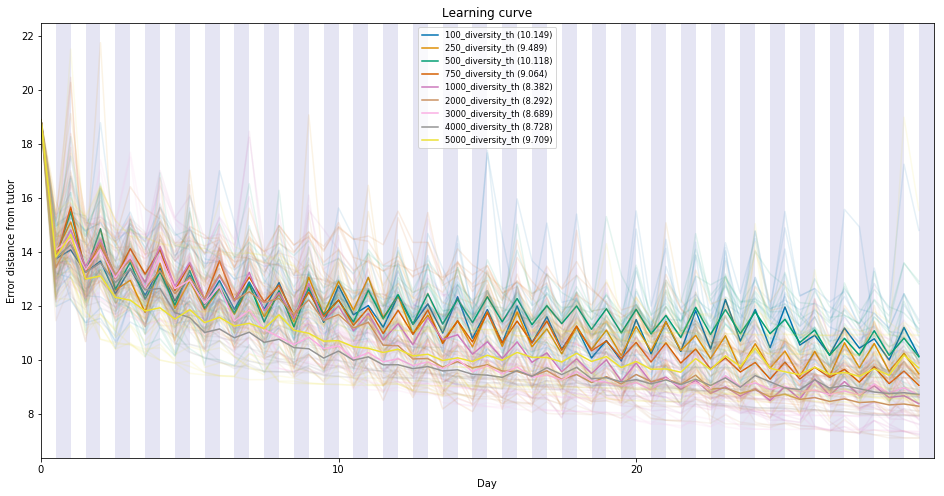

In [4]:
# -- Cluster simulations --
cluster_sim_path = res_path + 'nlm_div_th_test_180713_173751/'

param_filter = '0p_1rms'

aggregated_learning_curve(cluster_sim_path, param_filter=param_filter)

In [5]:
# # -- Cluster simulations --
# cluster_sim_path = res_path + 'pitch_rms_test_180712_103336/'

# param_filter = 'mutate_microbial_diversity_uniform'

# aggregated_learning_curve(cluster_sim_path, param_filter=param_filter)